# 1. Environment settings

# 1.1 Install dependencies and setup

We need to install tensorflow.

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
When installing tensorflow please make sure the it is listed in installed packages using commande pip list. 
</blockquote>

In [1]:
# import necessary packages 
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

C:\Users\gbencheikh\AppData\Local\Temp\ipykernel_1076\3328806441.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
dataset_dir = 'dataset'

To avoid Out Of Memory (OOM) errors please execute the following sub-code for setting GPU Memory Consumption Growth 

In [3]:
gpus = tf.config.experimental.list_logical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

# 2 Data cleaning 

Let's see a random image quality 

Image size = (432, 288, 3)


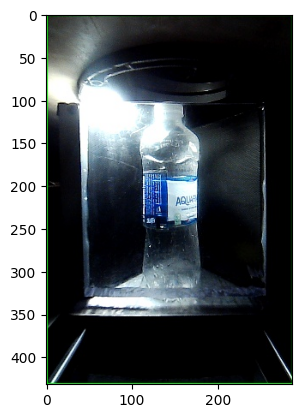

In [4]:
# plot an image 
img = cv2.imread(os.path.join(dataset_dir, 'aquafina', 'captured_image_173442_8.jpg'))
print('Image size =', img.shape)

# convert image colors from BGR to RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 2.1 Step 1 : remove all images of non compatible extension
accepted extensions 

In [5]:
image_extensions = ['.jpeg', '.jpg', '.png', '.bmp']

In [6]:
for image_class in os.listdir(dataset_dir):
    for image in os.listdir(os.path.join(dataset_dir, image_class)):
        image_path = os.path.join(dataset_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            _, tip = os.path.splitext(image_path)
            if tip not in image_extensions: 
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Error with image {}'.format(image_path))

## 2.2 Load data 
In this section we will use the tf.data.Dataset for image processing, for documentation about this tool, please execute the command: tf.data.Dataset??

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
Please make sure that all your images file names contain only utf_8 caracters 
</blockquote>

In [7]:
data = tf.keras.utils.image_dataset_from_directory(dataset_dir)
 
# Extract class names
class_names = data.class_names

Found 1412 files belonging to 9 classes.


In [8]:
# convert data into numpy iterator to access our data pipeline 
data_iterator = data.as_numpy_iterator()

#get another batch from iterator
batch = data_iterator.next()
# visulize one batch 
#batch[0]  # image represented as numpy array 
batch[1]  # labels 

array([1, 5, 2, 3, 8, 1, 8, 1, 8, 0, 8, 8, 6, 6, 7, 6, 5, 7, 7, 3, 7, 8,
       5, 1, 5, 7, 6, 2, 5, 7, 4, 7])

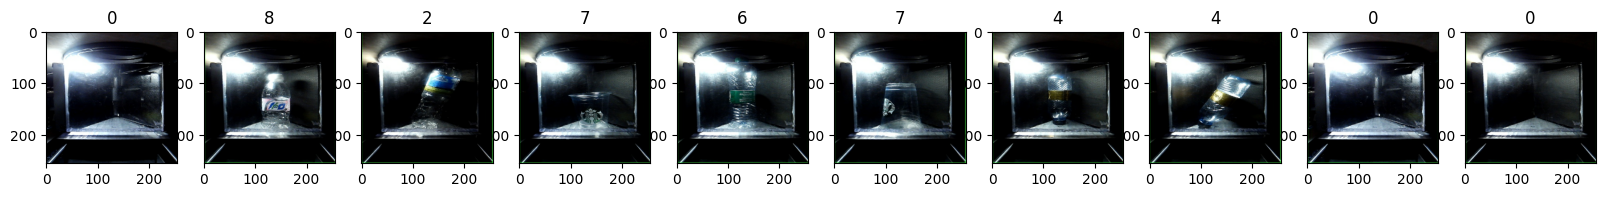

In [9]:
#get another batch from iterator
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
num_classes = len(class_names) # num_classes is the number of bottles categories
# Print and save class names to a file
print("Class Names:", class_names)

Class Names: ['0 Empty', 'Starbuck_Natural_Juice', 'Starbuck_water_bottle', 'aquafina', 'ival', 'nova', 'oska', 'plastic_cups', 'safa']


<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
So here we have our batch that contains our images and their corresponding labels. But the values are between 0 and 255. We want to optimiaze this values 
</blockquote>

## 2.2 Data pre-processing

### 2.2.1 Scale data 

we will transforme the values to smaller values to increse speed. (x value represents the image)

In [11]:
data = data.map(lambda x, y: (x / 255, tf.one_hot(tf.cast(y, tf.int32), depth=num_classes)))

scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [12]:
# Repeat the dataset
# data = data.repeat(20)

data values are now between 0 and 1. To make sure of this, let's print max and min values of data: 

In [13]:
print("Min value = ",data.as_numpy_iterator().next()[0].min()) 
print("Max value = ",data.as_numpy_iterator().next()[0].max()) 

Min value =  0.0
Max value =  1.0


Let's take a look at the images after scaling 

c:\Users\gbencheikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


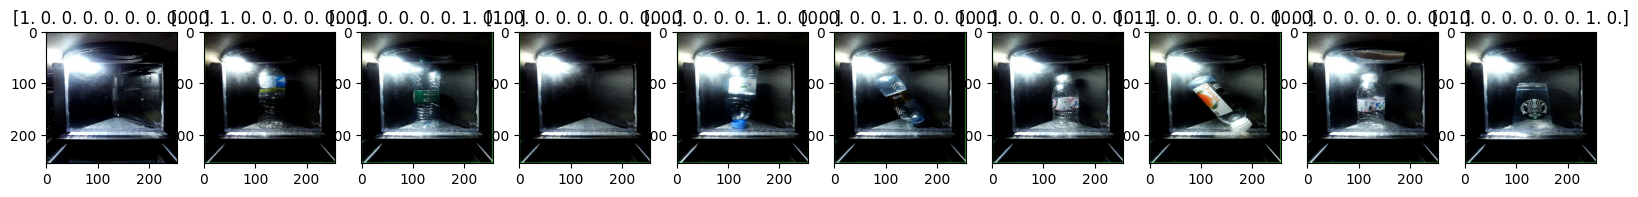

In [14]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 2.2.2 Split data (training, validation and test)

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = len(data) - train_size - val_size

Make sure that the sum of variables is equal to data length

In [16]:
print("data length =", len(data))
print("Parition is: ")
print("- train size=", train_size)
print("- validation size =", val_size)
print("- test size =", test_size)

if(train_size+ val_size+test_size != len(data)):
    print("Error: data spliting is not correctly done")
else: 
    print("Partition is good!, you can proceed.")

data length = 45
Parition is: 
- train size= 31
- validation size = 9
- test size = 5
Partition is good!, you can proceed.


In [17]:
# split dataset
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

We will use data augmentation technique to artificially increase the size of our training dataset by applying various transformations to the existing images. This helps the model become more robust and generalize better.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness randomly between 80% and 120%
    fill_mode='nearest'
)

batch_size = 32

# Convert tf.data.Dataset to NumPy arrays
train_numpy = np.concatenate([x for x, y in train.as_numpy_iterator()], axis=0)
train_labels = np.concatenate([y for x, y in train.as_numpy_iterator()], axis=0)
# Create a data generator for training with augmentation
train_dataset = datagen_train.flow(train_numpy, train_labels, batch_size=batch_size)

# Convert tf.data.Dataset to NumPy arrays for validation (without augmentation)
val_numpy = np.concatenate([x for x, y in val.as_numpy_iterator()], axis=0)
val_labels = np.concatenate([y for x, y in val.as_numpy_iterator()], axis=0)

# Create a data generator for validation without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((val_numpy, val_labels))
val_dataset = val_dataset.batch(batch_size)

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Summary</strong>
We have shuffeled and scaled our data. 

Data is devided into 3 classes: the two first classes are designed for trainning the deep learning model and the 3rd is for testing it.
</blockquote>

# 3. CNN model building 

## 3.1 Build deep leaning network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

input_shape = (256, 256, 3)

# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps to feed into densely connected layers
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(num_classes, activation='softmax'))  # Output layer

In [20]:
# Learning Rate Scheduler
initial_learning_rate = 0.0001

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    return lr

lr_schedule = LearningRateScheduler(lr_scheduler)

optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

## 3.2 Train model

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath="./model.h5", 
                      monitor="accuracy", 
                      verbose=1, 
                      save_best_only=True)

es = EarlyStopping(monitor="accuracy", 
                   min_delta=0.01,
                   patience = 5,
                   verbose=1)

logdir  = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # to save the model, for checking and logging and monitore training process 

# Fit the model
hist = model.fit(train, 
                 epochs=20, 
                 validation_data=val, 
                 callbacks=[tensorboard_callback, lr_schedule, mc, es])

Epoch 1/20




31/31 [==============================] - ETA: 0s - loss: 2.1089 - accuracy: 0.2359
Epoch 1: accuracy improved from -inf to 0.23589, saving model to .\model.h5


c:\Users\gbencheikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 102s 3s/step - loss: 2.1089 - accuracy: 0.2359 - val_loss: 1.8813 - val_accuracy: 0.3021 - lr: 1.0000e-04
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 1.8048 - accuracy: 0.3942
Epoch 2: accuracy improved from 0.23589 to 0.39415, saving model to .\model.h5
31/31 [==============================] - 97s 3s/step - loss: 1.8048 - accuracy: 0.3942 - val_loss: 1.2838 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 1.3832 - accuracy: 0.5343
Epoch 3: accuracy improved from 0.39415 to 0.53427, saving model to .\model.h5
31/31 [==============================] - 127s 4s/step - loss: 1.3832 - accuracy: 0.5343 - val_loss: 0.9293 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 4/20
31/31 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.6321
Epoch 4: accuracy improved from 0.53427 to 0.63206, saving model to .\model.h5
31/31 [==============================] - 

## 3.3 Plot performance

Loss function

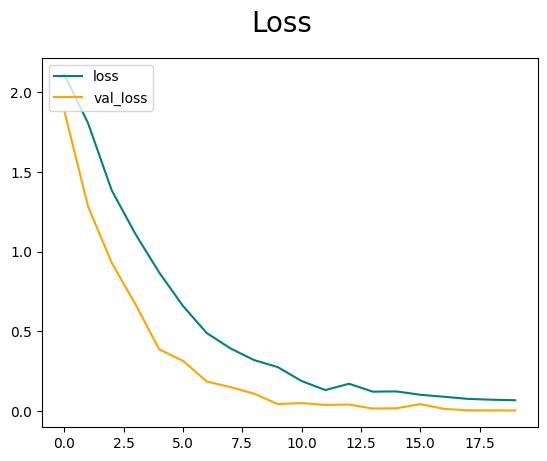

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Accuracy function

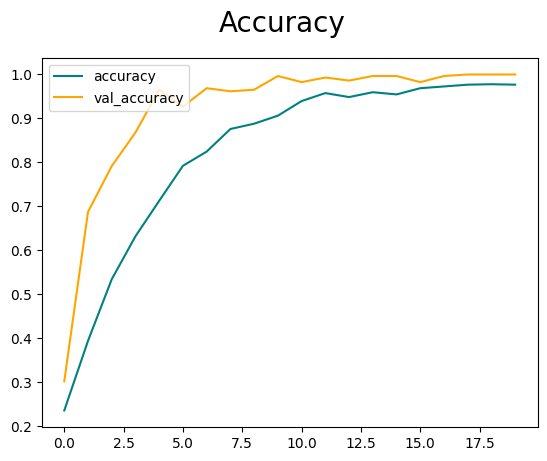

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 3.4 Evaluation 

In [25]:
from tensorflow.keras.metrics import CategoricalAccuracy

In [26]:
categorical_acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    categorical_acc.update_state(y, yhat)

accuracy = categorical_acc.result().numpy()
print(f'Categorical Accuracy: {accuracy}')

1/1 [==============================] - 0s 326ms/step
Categorical Accuracy: 1.0


## 3.5 Test 

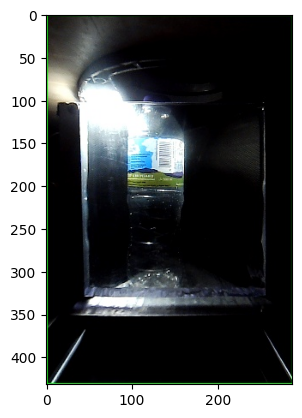

In [34]:
import cv2

img = cv2.imread('water_bottle_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [35]:
resize = tf.image.resize(img, (256, 256))
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0))
print("yhat=", yhat)


# identify the predicted class which cooreponds to the highest predicted probability
predicted_class = np.argmax(yhat)

# Get the corresponding probability
predicted_probability = yhat[0, predicted_class]

data = tf.keras.utils.image_dataset_from_directory(dataset_dir)
 
# Extract class names
class_names = data.class_names

print("Predicted Class: ", class_names[predicted_class])
print("Predicted Probability: ", predicted_probability)

1/1 [==============================] - 0s 39ms/step
yhat= [[1.5369392e-07 7.5505057e-05 9.9992001e-01 3.7879815e-07 6.2641838e-08
  9.8755254e-07 1.9161547e-07 2.1156818e-06 4.8362000e-07]]
Found 1412 files belonging to 9 classes.
Predicted Class:  Starbuck_water_bottle
Predicted Probability:  0.99992


# 4. Save the model and corresponding labels

## 4.1 save the whole model
<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
This method saves the entire model, including the architecture, optimizer, and learned weights
</blockquote>

In [29]:
model.save('model.h5')
model.save('Model/model.h5')
print("The model has been successfully saved.")

with open('labels.txt', 'w') as file:
    for id, class_name in enumerate(class_names):
        file.write(f"{id} {class_name}\n")
with open('Model/labels.txt', 'w') as file:
    for id, class_name in enumerate(class_names):
        file.write(f"{id} {class_name}\n")

The model has been successfully saved.


## 4.3 Save model architecture to JSON file

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
This method saves only the model architecture without the weights or optimizer information
</blockquote>


In [30]:
# 
model_json = model.to_json()
with open('your_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

print("The model has been succesfully saved into Json file")

The model has been succesfully saved into Json file
